# 5. Übung Nichtlineare Regelungstechnik 1, Aufgabe 2

## Untersuchung der Robustheit eines Reglers, der auf Basis einer Eingangs-Ausgangs-Linearisierung der Systemgleichungen entworfen wurde.

System:

\begin{align*}
\dot x_1 &= x_2 + \sin(x_1)\\
\dot x_2 &=ax_1^2 + u.
\end{align*}

mit $|a| < 2$

---

Die aktuelle Fassung dieses Notebooks findet sich in folgendem Repositorium:

https://gitlab.hrz.tu-chemnitz.de/rst/public/teaching/nl1-nbviewer-content

Sie können zur Entwicklung/ Verbesserung über Merge Requests beitragen!

---

<p style="font-family:Courier New; font-size:10pt">
Copyright (c) 2019-2023 Jan Winkler, TU Dresden, Germany
</p>

<p style="font-family:Courier New; font-size:10pt">
This program is free software: you can redistribute it and/or modify<br>
it under the terms of the GNU General Public License as published by<br>
the Free Software Foundation, either version 3 of the License, or<br>
(at your option) any later version.
</p>
    
<p style="font-family:Courier New; font-size:10pt">
This program is distributed in the hope that it will be useful,<br>
but WITHOUT ANY WARRANTY; without even the implied warranty of<br>
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the<br>
GNU General Public License for more details: <br>
<a href=https://www.gnu.org/licenses/gpl-3.0.txt>https://www.gnu.org/licenses/gpl-3.0.txt</a>.
</p>


---

## Vorbereitungen für die Simulation

### Benötigte Pakete

In [1]:
import numpy as np
import scipy.integrate as sci
import matplotlib.pyplot as plt
#%matplotlib widget

## Definition des Regelgesetzes

In der Übung wurde folgendes exakt linearisierende Regelgesetz mit Aufprägung einer stabilen Dynamik zweiter Ordnung hergeleitet:

\begin{equation*}
u = -a x_1^2 - \cos(x_1)\cdot (x_2 + \sin(x_1)) + \ddot y_\text{ref} - k_1(\dot y - \dot y_\text{ref}) - k_0(y - y_\text{ref})
\end{equation*}

In [2]:
def controller(x1, x2, x1_dot, y_ref, k_0, k_1, a):
    """ Regelgesetz

    Args:
        x1 (float): Wert von x_1
        x2 (float): Wert von x_2
        x3 (float): Wert der Zeitbaleitung von x_1
        yref (array_like): Referenzwert von y and dessen erste beiden Ableitungen
        k_0 (float): Reglerparameter k_0
        k_1 (float): Reglerparameter k_1
        a (float): Systemparameter a (Entwurfswert)
    """
    v = y_ref[2] - k_1 * (x1_dot - y_ref[1]) - k_0 * (x1 - y_ref[0])

    return -a * x1**2 - np.cos(x1) * (x2 + np.sin(x1)) + v

## Dgl. des geschlossenen Kreises

In [3]:
def dgl_sys(t, x, y_ref, k0, k1, a, a_real):
    """ Rechte Seite des geschlossenen Regelkreises (System + Regler)

    Args:
        t (float): Zeit
        x (array_like): Zustand (x[0] -> x1, x[1] -> x2]
        yref (array_like): Referenzwert von y and dessen erste beiden Ableitungen
        k_0 (float): Reglerparameter k_0
        k_1 (float): Reglerparameter k_1
        a (float): Systemparameter a
        a_real (float): Systemparameter a, der im Regler verwendet wird
    """
    x1, x2 = x

    # 1. Dgl. (Wert wird für Regler benötigt)
    x1_dot = x2 + np.sin(x1)

    # Regler (mit Nominalwert für a!)
    u = controller(x1, x2, x1_dot, y_ref, k0, k1, a)

    # 2. Dgl. (mit realem Wert für a!)
    x2_dot = a_real * x1**2 + u

    return np.array([x1_dot, x2_dot])

## Definition des Stop-Events

Da der Regler das System bei Betrieb außerhalb der Spezifikation nicht stabilisieren kann, muss die Simulation in diesen Fällen abgebrochen werden. Ansonsten werden die Werte der Zustandskomponenten so groß, dass man auf dem Plot nichts erkennen kann. Hierzu wird dem Gleichungslöser diese Funktion übergeben, die ein Stop-Ereignis aulöst, sobald der Abstand des Zustands zum Ursprung größer ist als 10.

<div class="alert alert-block alert-info">
    <b>Tip:</b> Schauen Sie in der <a href=https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html>Dokumentation des Dgl-Lösers</a> nach, um sich genauer zu informieren. In Matlab ist unter dem Sichwort <a href=https://www.mathworks.com/help/matlab/math/ode-event-location.html>ode event</a> nachzusehen.
</div>

In [4]:
def stop_event(t, x):
    return np.linalg.norm(x) - 10


stop_event.terminal = True
stop_event.direction = 1

## Definition der Simulationsparameter

Es werden verschiedene Werte für das reale $a$ angegeben (`paras_a_real`). Der Regler läuft jedoch mit dem in `para_a` festlegten Wert. Beobachtung: Wenn $k_0 = 1$ und $k_1 = 2$ gewählt wurden (d.h., die Eigenwerte der Fehlerdynamik liegen bei -1), dann kann $a$ zwischen -1.2 und 1.4 liegen, sofern der Anfangswert lautet $x_{01} = 2$, $x_{02} = 3$ (so wie in den Backstepping- und Sliging-Mode-Simulationen auch, der Regler wird also eingeschaltet, während das System irgendwie in Bewegung ist).

In [5]:
t = np.linspace(0, 15, 501)
x0 = [2, 3]
para_a = 1.0  # für Regler
paras_a_real = [-0.8, -0.2, 0.5, 1.0, 1.2, 1.5]  # geht von -0.8 bis bis 1.2 bei k0 = 1 und k1 = 2 (EW bei -1), x01 = 2, x02 = 3
para_k0 = 1
para_k1 = 2

## Durchführung der Simulation für $y_{ref} \equiv 0$ und $y_{ref} \equiv 1$

Da die Simulation mit einem Löser mit variabler Schrittweite durchgeführt wird, kann die Stellgröße $u$ nicht innerhalb der Dgl.-Funktion abgespeichert werden. Sie muss daher nach der Simulation noch einmal nachberechnet werden.

In [6]:
yrefs = [[0.0, 0.0, 0.0], [1.0, 0.0, 0.0]]  # Ableitungen sind jeweils Null!
result_x = []
result_t = []
result_u = []
for yref in yrefs:
    result_x.append([])  # geht auch eleganter...
    result_t.append([])
    result_u.append([])
    for p_a_real in paras_a_real:
        sol = sci.solve_ivp(lambda t, x: dgl_sys(t, x, yref, para_k0, para_k1, para_a, p_a_real), [t[0], t[-1]], x0, t_eval=t, events=[stop_event])
        result_x[-1].append(sol.y)
        result_t[-1].append(sol.t)

        # Verlauf der Stellgröße nachberechnen
        u = np.zeros_like(sol.t)
        for j, t_act in enumerate(sol.t):
            x1_dot, x2_dot = dgl_sys(t_act, sol.y[:, j], yref, para_k0, para_k1, para_a, p_a_real)
            u[j] = controller(sol.y[0, j], sol.y[1, j], x1_dot, yref, para_k0, para_k1, para_a)
        result_u[-1].append(u)

In [7]:
len(result_x[0])

6

## Darstellung der Ergebnisse für $y_{ref} \equiv 0$

Für $a = 1.5$, also 0.5 über dem Nominalwert, versagt die Stabilisierung. Die gewünschte Ruhelge $y_{ref} \equiv 0$ wird für die anderen Werte stabilisiert.

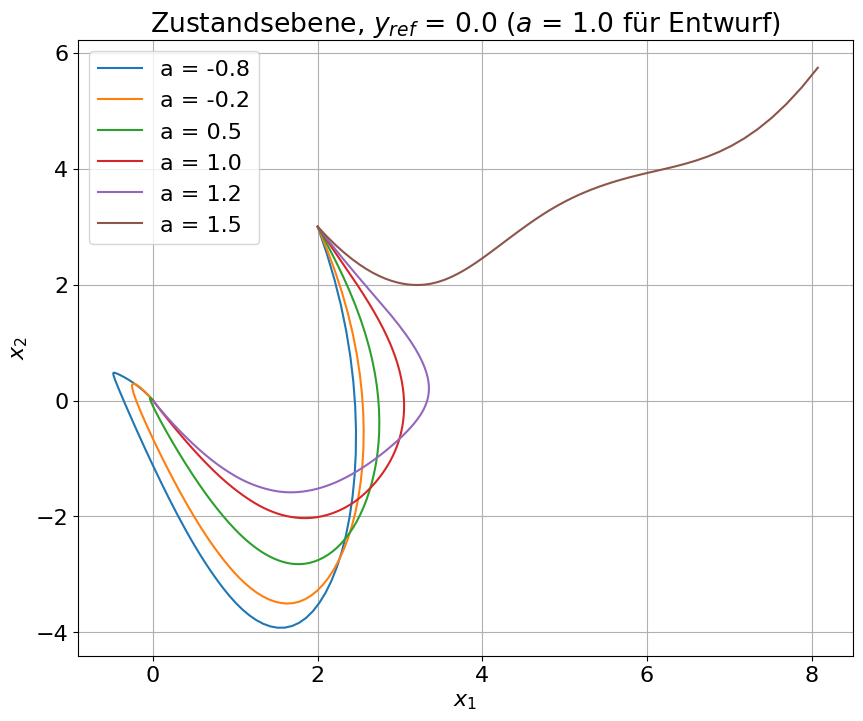

In [8]:
plt.rcParams['font.size'] = '16'
plt.figure(figsize=(10,8))
for i, x in enumerate(result_x[0]):
    plt.plot(x[0, :], x[1, :], label="a = {}".format(paras_a_real[i]))
plt.grid()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Zustandsebene, $y_{{ref}}$ = {0} ($a$ = {1} für Entwurf)'.format(0.0, para_a))
plt.legend()
# plt.savefig("asinus_x1x2_a_variabel.png", dpi=300)

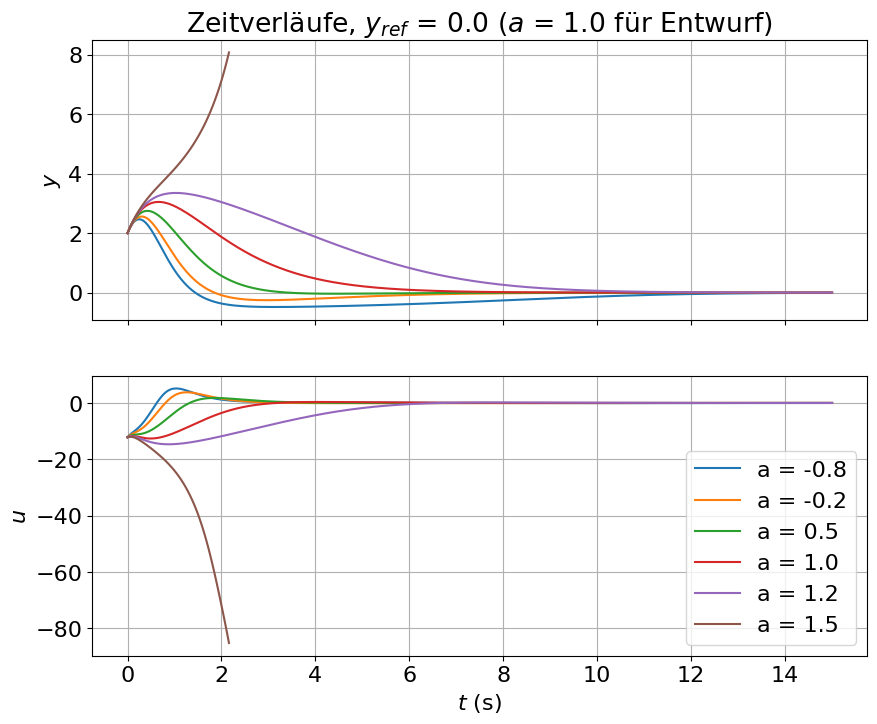

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,8))
for i, x in enumerate(result_x[0]):
    ax[0].plot(result_t[0][i], x[0, :], label='a = {}'.format(paras_a_real[i]))
    ax[1].plot(result_t[0][i], result_u[0][i], label='a = {}'.format(paras_a_real[i]))
ax[0].set_title('Zeitverläufe, $y_{{ref}}$ = {0} ($a$ = {1} für Entwurf)'.format(0.0, para_a))
ax[0].set_ylabel('$y$')
ax[0].grid()
ax[1].set_ylabel('$u$')
ax[1].set_xlabel('$t$ (s)')
ax[1].grid()
ax[1].legend(loc='lower right')
# plt.savefig("asinus_yut_a_variabel.png", dpi=300)

## Darstellung der Ergebnisse für $y_{ref} \equiv 1.0$

Wir wiederholen die Simulation jetzt, geben jedoch einen Referenzwert ungleich 0 vor. Es zeigt sich, wie in der Übung untersucht, dass das System zwar stabilisert wird, der gewünschte Referenzwert aber nicht genau getroffen wird. Außerdem versagt die Stabilisierung bereits bei $a \geq$ 1.2.

In [10]:
plt.rcParams['font.size'] = '16'
plt.figure(figsize=(10,8))
for i, x in enumerate(result_x[1]):
    plt.plot(x[0, :], x[1, :], label="a = {}".format(paras_a_real[i]))
plt.grid()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Zustandsebene, $y_{{ref}}$ = {0} ($a$ = {1} für Entwurf)'.format(yrefs[1][0], para_a))
plt.legend()
# plt.savefig("asinus_x1x2_a_variabel_yref1.png", dpi=300)

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,8))
for i, x in enumerate(result_x[1]):
    ax[0].plot(result_t[1][i], x[0, :], label='a = {}'.format(paras_a_real[i]))
    ax[1].plot(result_t[1][i], result_u[1][i], label='a = {}'.format(paras_a_real[i]))
ax[0].set_title('Zeitverläufe, $y_{{ref}}$ = {0} ($a$ = {1} für Entwurf)'.format(yrefs[1][0], para_a))
ax[0].set_ylabel('$y$')
ax[0].set_ylim([-1.0, 5.0])
ax[0].grid()
ax[1].set_ylabel('$u$')
ax[1].set_xlabel('$t$ (s)')
ax[1].grid()
ax[1].legend(loc='lower right')
# plt.savefig("asinus_yut_a_variabel_yref1.png", dpi=300)